<a href="https://colab.research.google.com/github/NivedhaBalakrishnan/Data-Science-Protfolio/blob/main/Medical%20Image%20Segmentation/UNet%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mounting Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
cd drive/Shareddrives/Interview\ Preparation/Data\ Science/Image Segmentation

[Errno 2] No such file or directory: 'drive/Shareddrives/Interview Preparation/Data Science/Image Segmentation'
/content/drive/Shareddrives/Interview Preparation/Data Science/Image Segmentation


In [25]:
ls

data/  input/  lib/  notebook/  output/  source/


In [4]:
import os
import yaml
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim

from glob import glob
from tqdm import tqdm
from collections import OrderedDict
from albumentations.augmentations import transforms
from sklearn.model_selection import train_test_split
from albumentations.core.composition import Compose, OneOf

# from train import train, validate
# from source.network import UNetPP
# from source.dataset import DataSet

In [5]:
import os
import cv2
import numpy as np
import torch.utils.data


class DataSet(torch.utils.data.Dataset):
    def __init__(self, img_ids, img_dir, mask_dir, img_ext, mask_ext, transform=None):
        self.img_ids = img_ids
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_ext = img_ext
        self.mask_ext = mask_ext
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]

        img = cv2.imread(os.path.join(self.img_dir, img_id + self.img_ext))

        mask = []
        mask.append(cv2.imread(os.path.join(self.mask_dir,
                                            img_id + self.mask_ext), cv2.IMREAD_GRAYSCALE)[..., None])
        mask = np.dstack(mask)

        if self.transform is not None:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        img = img.astype('float32') / 255
        img = img.transpose(2, 0, 1)
        mask = mask.astype('float32') / 255
        mask = mask.transpose(2, 0, 1)

        return img, mask, {'img_id': img_id}



In [6]:
import torch
from torch import nn


class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out


class UNetPP(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return output


In [7]:
import torch


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def iou_score(output, target):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)


In [8]:
import os
import yaml
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim

from glob import glob
from tqdm import tqdm
from collections import OrderedDict
from source.ML_Pipeline.utils import iou_score, AverageMeter
from albumentations import Resize
from albumentations.augmentations import transforms
from sklearn.model_selection import train_test_split
from albumentations.core.composition import Compose, OneOf
from albumentations.augmentations.geometric.rotate import RandomRotate90
from source.ML_Pipeline.network import UNetPP
from source.ML_Pipeline.dataset import DataSet


def train(deep_sup, train_loader, model, criterion, optimizer):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}

    model.train()

    pbar = tqdm(total=len(train_loader))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for input, target, _ in train_loader:
        input = input.to(device)
        target = target.to(device)

        # compute output
        if deep_sup:
            outputs = model(input)
            loss = 0
            for output in outputs:
                loss += criterion(output, target)
            loss /= len(outputs)
            iou = iou_score(outputs[-1], target)
        else:
            output = model(input)
            loss = criterion(output, target)
            iou = iou_score(output, target)

        # compute gradient and do optimizing step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_meters['loss'].update(loss.item(), input.size(0))
        avg_meters['iou'].update(iou, input.size(0))

        postfix = OrderedDict([
            ('loss', avg_meters['loss'].avg),
            ('iou', avg_meters['iou'].avg),
        ])
        pbar.set_postfix(postfix)
        pbar.update(1)
    pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg)])


def validate(deep_sup, val_loader, model, criterion):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}

    # switch to evaluate mode
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        pbar = tqdm(total=len(val_loader))
        for input, target, _ in val_loader:
            input = input.to(device)
            target = target.to(device)

            # compute output
            if deep_sup:
                outputs = model(input)
                loss = 0
                for output in outputs:
                    loss += criterion(output, target)
                loss /= len(outputs)
                iou = iou_score(outputs[-1], target)
            else:
                output = model(input)
                loss = criterion(output, target)
                iou = iou_score(output, target)

            avg_meters['loss'].update(loss.item(), input.size(0))
            avg_meters['iou'].update(iou, input.size(0))

            postfix = OrderedDict([
                ('loss', avg_meters['loss'].avg),
                ('iou', avg_meters['iou'].avg),
            ])
            pbar.set_postfix(postfix)
            pbar.update(1)
        pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg)])


In [9]:
import cv2
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt

from source.ML_Pipeline.network import UNetPP
from argparse import ArgumentParser
import albumentations as A
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose


val_transform = Compose([
    A.Resize(256, 256),
    transforms.Normalize(),
])


def image_loader(image_name):
    img = cv2.imread(image_name)
    img = val_transform(image=img)["image"]
    img = img.astype('float32') / 255
    img = img.transpose(2, 0, 1)

    return img

In [10]:
with open("source/config.yaml") as f:
    config = yaml.safe_load(f)

extn = config["extn"]
epochs = config["epochs"]
log_path = config["log_path"]
mask_path = config["mask_path"]
image_path = config["image_path"]
model_path = config["model_path"]

## Create log file

In [11]:
log = OrderedDict([
    ('epoch', []),
    ('loss', []),
    ('iou', []),
    ('val_loss', []),
    ('val_iou', []),
])

best_iou = 0
trigger = 0

## Split images into train and validation set

In [12]:
import glob

extn_ = f"*{extn}"
img_ids = glob.glob(os.path.join(image_path, extn_))
img_ids = [os.path.splitext(os.path.basename(p))[0] for p in img_ids]
train_img_ids, val_img_ids = train_test_split(img_ids, test_size=0.2)

## Define data transformations

In [13]:
train_transform = Compose([
    A.RandomRotate90(),
    transforms.Flip(),
    OneOf([
        transforms.HueSaturationValue(),
        transforms.RandomBrightness(),
        transforms.RandomBrightnessContrast(),
    ], p=1),
    A.Resize(256, 256),
    transforms.Normalize(),
])

val_transform = Compose([
    A.Resize(256, 256),
    transforms.Normalize(),
])

/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


## Create train and validation dataset

In [14]:
train_dataset = DataSet(
    img_ids=train_img_ids,
    img_dir=image_path,
    mask_dir=mask_path,
    img_ext=extn,
    mask_ext=extn,
    transform=train_transform)

val_dataset = DataSet(
    img_ids=val_img_ids,
    img_dir=image_path,
    mask_dir=mask_path,
    img_ext=extn,
    mask_ext=extn,
    transform=val_transform)

## Create train and validation data loaders

In [15]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    drop_last=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    drop_last=False)

## Create the model object

In [16]:
# Create model object
model = UNetPP(1, 3, True)

# Port model to GPU if it is available
if torch.cuda.is_available():
    model.cuda()
    
# Define Loss Function
criterion = nn.BCEWithLogitsLoss()
params = filter(lambda p: p.requires_grad, model.parameters())

# Define Optimizer
optimizer = optim.Adam(params, lr=1e-3, weight_decay=1e-4)

## Run the train loop

In [17]:
for epoch in range(epochs):
    print(f'Epoch [{epoch}/{epochs}]')

    # train for one epoch
    train_log = train(True, train_loader, model, criterion, optimizer)
    # evaluate on validation set
    val_log = validate(True, val_loader, model, criterion)

    print('loss %.4f - iou %.4f - val_loss %.4f - val_iou %.4f'
              % (train_log['loss'], train_log['iou'], val_log['loss'], val_log['iou']))

    log['epoch'].append(epoch)
    log['loss'].append(train_log['loss'])
    log['iou'].append(train_log['iou'])  
    log['val_loss'].append(val_log['loss'])
    log['val_iou'].append(val_log['iou'])

    pd.DataFrame(log).to_csv(log_path, index=False)

    trigger += 1

    if val_log['iou'] > best_iou:
        torch.save(model.state_dict(), model_path)
        best_iou = val_log['iou']
        print("=> saved best model")
        trigger = 0

Epoch [0/300]


100%|██████████| 8/8 [01:44<00:00, 13.12s/it, loss=0.544, iou=0.000173]


loss 0.5062 - iou 0.0814 - val_loss 0.5442 - val_iou 0.0002
=> saved best model
Epoch [1/300]


100%|██████████| 8/8 [00:03<00:00,  2.04it/s, loss=0.367, iou=1.28e-10]


loss 0.3810 - iou 0.0079 - val_loss 0.3673 - val_iou 0.0000
Epoch [2/300]


100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.336, iou=1.28e-10]


loss 0.3289 - iou 0.0122 - val_loss 0.3363 - val_iou 0.0000
Epoch [3/300]


100%|██████████| 8/8 [00:03<00:00,  2.08it/s, loss=0.353, iou=0.00239]


loss 0.2965 - iou 0.0121 - val_loss 0.3531 - val_iou 0.0024
=> saved best model
Epoch [4/300]


100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.316, iou=0.0241]


loss 0.2767 - iou 0.0055 - val_loss 0.3156 - val_iou 0.0241
=> saved best model
Epoch [5/300]


100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.26, iou=1.28e-10]


loss 0.2709 - iou 0.0141 - val_loss 0.2604 - val_iou 0.0000
Epoch [6/300]


100%|██████████| 8/8 [00:03<00:00,  2.01it/s, loss=0.243, iou=1.28e-10]


loss 0.2608 - iou 0.0003 - val_loss 0.2432 - val_iou 0.0000
Epoch [7/300]


100%|██████████| 8/8 [00:04<00:00,  1.97it/s, loss=0.244, iou=1.28e-10]


loss 0.2611 - iou 0.0001 - val_loss 0.2442 - val_iou 0.0000
Epoch [8/300]


100%|██████████| 8/8 [00:04<00:00,  1.94it/s, loss=0.281, iou=1.28e-10]


loss 0.2549 - iou 0.0004 - val_loss 0.2815 - val_iou 0.0000
Epoch [9/300]


100%|██████████| 8/8 [00:04<00:00,  1.90it/s, loss=0.284, iou=1.28e-10]


loss 0.2486 - iou 0.0011 - val_loss 0.2837 - val_iou 0.0000
Epoch [10/300]


100%|██████████| 8/8 [00:04<00:00,  1.90it/s, loss=0.248, iou=1.28e-10]


loss 0.2462 - iou 0.0196 - val_loss 0.2482 - val_iou 0.0000
Epoch [11/300]


100%|██████████| 8/8 [00:04<00:00,  1.96it/s, loss=0.245, iou=1.28e-10]


loss 0.2486 - iou 0.0028 - val_loss 0.2452 - val_iou 0.0000
Epoch [12/300]


100%|██████████| 8/8 [00:03<00:00,  2.00it/s, loss=0.234, iou=0.0157]


loss 0.2424 - iou 0.0680 - val_loss 0.2336 - val_iou 0.0157
Epoch [13/300]


100%|██████████| 8/8 [00:03<00:00,  2.02it/s, loss=0.242, iou=0.124]


loss 0.2386 - iou 0.0861 - val_loss 0.2420 - val_iou 0.1235
=> saved best model
Epoch [14/300]


100%|██████████| 8/8 [00:03<00:00,  2.06it/s, loss=0.235, iou=1.28e-10]


loss 0.2411 - iou 0.0841 - val_loss 0.2353 - val_iou 0.0000
Epoch [15/300]


100%|██████████| 8/8 [00:03<00:00,  2.06it/s, loss=0.224, iou=0.0232]


loss 0.2415 - iou 0.0711 - val_loss 0.2241 - val_iou 0.0232
Epoch [16/300]


100%|██████████| 8/8 [00:03<00:00,  2.03it/s, loss=0.252, iou=0.227]


loss 0.2358 - iou 0.1395 - val_loss 0.2523 - val_iou 0.2265
=> saved best model
Epoch [17/300]


100%|██████████| 8/8 [00:03<00:00,  2.04it/s, loss=0.226, iou=0.0978]


loss 0.2338 - iou 0.1129 - val_loss 0.2261 - val_iou 0.0978
Epoch [18/300]


100%|██████████| 8/8 [00:03<00:00,  2.06it/s, loss=0.385, iou=0.155]


loss 0.2306 - iou 0.1745 - val_loss 0.3851 - val_iou 0.1554
Epoch [19/300]


100%|██████████| 8/8 [00:03<00:00,  2.05it/s, loss=0.299, iou=0.257]


loss 0.2267 - iou 0.2202 - val_loss 0.2995 - val_iou 0.2573
=> saved best model
Epoch [20/300]


100%|██████████| 8/8 [00:03<00:00,  2.08it/s, loss=0.249, iou=1.28e-10]


loss 0.2352 - iou 0.1491 - val_loss 0.2485 - val_iou 0.0000
Epoch [21/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.467, iou=0.161]


loss 0.2257 - iou 0.1796 - val_loss 0.4674 - val_iou 0.1613
Epoch [22/300]


100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.27, iou=1.28e-10]


loss 0.2257 - iou 0.2338 - val_loss 0.2705 - val_iou 0.0000
Epoch [23/300]


100%|██████████| 8/8 [00:03<00:00,  2.05it/s, loss=0.233, iou=0.19]


loss 0.2299 - iou 0.2069 - val_loss 0.2332 - val_iou 0.1902
Epoch [24/300]


100%|██████████| 8/8 [00:03<00:00,  2.03it/s, loss=0.258, iou=1.28e-10]


loss 0.2280 - iou 0.2254 - val_loss 0.2577 - val_iou 0.0000
Epoch [25/300]


100%|██████████| 8/8 [00:04<00:00,  1.97it/s, loss=0.222, iou=0.0234]


loss 0.2198 - iou 0.2647 - val_loss 0.2223 - val_iou 0.0234
Epoch [26/300]


100%|██████████| 8/8 [00:04<00:00,  1.95it/s, loss=0.328, iou=0.211]


loss 0.2227 - iou 0.2092 - val_loss 0.3283 - val_iou 0.2113
Epoch [27/300]


100%|██████████| 8/8 [00:04<00:00,  1.89it/s, loss=0.249, iou=1.28e-10]


loss 0.2196 - iou 0.2647 - val_loss 0.2487 - val_iou 0.0000
Epoch [28/300]


100%|██████████| 8/8 [00:04<00:00,  1.91it/s, loss=0.493, iou=0.246]


loss 0.2175 - iou 0.2940 - val_loss 0.4931 - val_iou 0.2456
Epoch [29/300]


100%|██████████| 8/8 [00:04<00:00,  1.94it/s, loss=0.257, iou=1.28e-10]


loss 0.2116 - iou 0.3012 - val_loss 0.2570 - val_iou 0.0000
Epoch [30/300]


100%|██████████| 8/8 [00:04<00:00,  1.98it/s, loss=0.26, iou=0.0501]


loss 0.2215 - iou 0.2513 - val_loss 0.2602 - val_iou 0.0501
Epoch [31/300]


100%|██████████| 8/8 [00:03<00:00,  2.02it/s, loss=0.208, iou=0.324]


loss 0.2146 - iou 0.3120 - val_loss 0.2076 - val_iou 0.3238
=> saved best model
Epoch [32/300]


100%|██████████| 8/8 [00:03<00:00,  2.03it/s, loss=0.659, iou=0.151]


loss 0.2128 - iou 0.3040 - val_loss 0.6587 - val_iou 0.1508
Epoch [33/300]


100%|██████████| 8/8 [00:03<00:00,  2.06it/s, loss=0.257, iou=0.121]


loss 0.2152 - iou 0.2952 - val_loss 0.2572 - val_iou 0.1207
Epoch [34/300]


100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.27, iou=1.28e-10]


loss 0.2134 - iou 0.3180 - val_loss 0.2702 - val_iou 0.0000
Epoch [35/300]


100%|██████████| 8/8 [00:03<00:00,  2.06it/s, loss=0.249, iou=0.00126]


loss 0.2101 - iou 0.3349 - val_loss 0.2489 - val_iou 0.0013
Epoch [36/300]


100%|██████████| 8/8 [00:03<00:00,  2.06it/s, loss=0.242, iou=0.00236]


loss 0.2068 - iou 0.3507 - val_loss 0.2419 - val_iou 0.0024
Epoch [37/300]


100%|██████████| 8/8 [00:03<00:00,  2.04it/s, loss=0.7, iou=0.149]


loss 0.2079 - iou 0.3712 - val_loss 0.7002 - val_iou 0.1493
Epoch [38/300]


100%|██████████| 8/8 [00:03<00:00,  2.05it/s, loss=0.247, iou=1.28e-10]


loss 0.2053 - iou 0.3806 - val_loss 0.2474 - val_iou 0.0000
Epoch [39/300]


100%|██████████| 8/8 [00:03<00:00,  2.06it/s, loss=0.338, iou=1.28e-10]


loss 0.2062 - iou 0.3531 - val_loss 0.3380 - val_iou 0.0000
Epoch [40/300]


100%|██████████| 8/8 [00:03<00:00,  2.06it/s, loss=0.248, iou=0.0539]


loss 0.2004 - iou 0.4077 - val_loss 0.2485 - val_iou 0.0539
Epoch [41/300]


100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.26, iou=1.28e-10]


loss 0.2012 - iou 0.3878 - val_loss 0.2598 - val_iou 0.0000
Epoch [42/300]


100%|██████████| 8/8 [00:03<00:00,  2.02it/s, loss=0.224, iou=0.0743]


loss 0.1953 - iou 0.4132 - val_loss 0.2241 - val_iou 0.0743
Epoch [43/300]


100%|██████████| 8/8 [00:03<00:00,  2.00it/s, loss=0.268, iou=0.142]


loss 0.1946 - iou 0.4415 - val_loss 0.2684 - val_iou 0.1416
Epoch [44/300]


100%|██████████| 8/8 [00:04<00:00,  1.95it/s, loss=0.274, iou=1.28e-10]


loss 0.2025 - iou 0.3747 - val_loss 0.2742 - val_iou 0.0000
Epoch [45/300]


100%|██████████| 8/8 [00:04<00:00,  1.91it/s, loss=0.219, iou=0.118]


loss 0.1961 - iou 0.4240 - val_loss 0.2189 - val_iou 0.1182
Epoch [46/300]


100%|██████████| 8/8 [00:04<00:00,  1.94it/s, loss=0.278, iou=1.28e-10]


loss 0.1868 - iou 0.4694 - val_loss 0.2783 - val_iou 0.0000
Epoch [47/300]


100%|██████████| 8/8 [00:04<00:00,  1.94it/s, loss=0.347, iou=1.28e-10]


loss 0.1810 - iou 0.4805 - val_loss 0.3473 - val_iou 0.0000
Epoch [48/300]


100%|██████████| 8/8 [00:04<00:00,  1.99it/s, loss=0.279, iou=1.28e-10]


loss 0.1872 - iou 0.4756 - val_loss 0.2787 - val_iou 0.0000
Epoch [49/300]


100%|██████████| 8/8 [00:03<00:00,  2.03it/s, loss=0.281, iou=3.59e-6]


loss 0.1926 - iou 0.4437 - val_loss 0.2812 - val_iou 0.0000
Epoch [50/300]


100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.281, iou=1.28e-10]


loss 0.1824 - iou 0.5018 - val_loss 0.2808 - val_iou 0.0000
Epoch [51/300]


100%|██████████| 8/8 [00:03<00:00,  2.06it/s, loss=0.275, iou=0.0058]


loss 0.1839 - iou 0.4891 - val_loss 0.2751 - val_iou 0.0058
Epoch [52/300]


100%|██████████| 8/8 [00:03<00:00,  2.05it/s, loss=0.237, iou=0.0645]


loss 0.1859 - iou 0.4819 - val_loss 0.2368 - val_iou 0.0645
Epoch [53/300]


100%|██████████| 8/8 [00:03<00:00,  2.06it/s, loss=0.201, iou=0.277]


loss 0.1795 - iou 0.5048 - val_loss 0.2009 - val_iou 0.2767
Epoch [54/300]


100%|██████████| 8/8 [00:03<00:00,  2.06it/s, loss=0.257, iou=0.0933]


loss 0.1812 - iou 0.5000 - val_loss 0.2565 - val_iou 0.0933
Epoch [55/300]


100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.239, iou=0.102]


loss 0.1768 - iou 0.5278 - val_loss 0.2394 - val_iou 0.1022
Epoch [56/300]


100%|██████████| 8/8 [00:03<00:00,  2.06it/s, loss=0.267, iou=0.0184]


loss 0.1757 - iou 0.5318 - val_loss 0.2670 - val_iou 0.0184
Epoch [57/300]


100%|██████████| 8/8 [00:03<00:00,  2.06it/s, loss=0.274, iou=0.156]


loss 0.1767 - iou 0.5239 - val_loss 0.2741 - val_iou 0.1562
Epoch [58/300]


100%|██████████| 8/8 [00:03<00:00,  2.06it/s, loss=0.312, iou=1.28e-10]


loss 0.1746 - iou 0.5269 - val_loss 0.3121 - val_iou 0.0000
Epoch [59/300]


100%|██████████| 8/8 [00:03<00:00,  2.06it/s, loss=0.224, iou=0.263]


loss 0.1729 - iou 0.5528 - val_loss 0.2242 - val_iou 0.2631
Epoch [60/300]


100%|██████████| 8/8 [00:04<00:00,  2.00it/s, loss=0.223, iou=0.097]


loss 0.1655 - iou 0.5775 - val_loss 0.2230 - val_iou 0.0970
Epoch [61/300]


100%|██████████| 8/8 [00:04<00:00,  1.99it/s, loss=0.333, iou=0.000257]


loss 0.1726 - iou 0.5439 - val_loss 0.3329 - val_iou 0.0003
Epoch [62/300]


100%|██████████| 8/8 [00:04<00:00,  1.97it/s, loss=0.288, iou=2.35e-5]


loss 0.1696 - iou 0.5455 - val_loss 0.2880 - val_iou 0.0000
Epoch [63/300]


100%|██████████| 8/8 [00:04<00:00,  1.91it/s, loss=0.204, iou=0.23]


loss 0.1705 - iou 0.5444 - val_loss 0.2039 - val_iou 0.2302
Epoch [64/300]


100%|██████████| 8/8 [00:04<00:00,  1.94it/s, loss=0.306, iou=1.28e-10]


loss 0.1615 - iou 0.5778 - val_loss 0.3059 - val_iou 0.0000
Epoch [65/300]


100%|██████████| 8/8 [00:04<00:00,  1.98it/s, loss=0.224, iou=0.127]


loss 0.1626 - iou 0.5910 - val_loss 0.2242 - val_iou 0.1268
Epoch [66/300]


100%|██████████| 8/8 [00:03<00:00,  2.00it/s, loss=0.184, iou=0.461]


loss 0.1633 - iou 0.5698 - val_loss 0.1838 - val_iou 0.4610
=> saved best model
Epoch [67/300]


100%|██████████| 8/8 [00:03<00:00,  2.05it/s, loss=0.273, iou=0.00965]


loss 0.1658 - iou 0.5784 - val_loss 0.2735 - val_iou 0.0096
Epoch [68/300]


100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.193, iou=0.302]


loss 0.1612 - iou 0.5794 - val_loss 0.1932 - val_iou 0.3017
Epoch [69/300]


100%|██████████| 8/8 [00:03<00:00,  2.06it/s, loss=0.266, iou=1.28e-10]


loss 0.1594 - iou 0.6214 - val_loss 0.2655 - val_iou 0.0000
Epoch [70/300]


100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.305, iou=1.28e-10]


loss 0.1612 - iou 0.5970 - val_loss 0.3053 - val_iou 0.0000
Epoch [71/300]


100%|██████████| 8/8 [00:03<00:00,  2.08it/s, loss=0.289, iou=1.28e-10]


loss 0.1568 - iou 0.6060 - val_loss 0.2889 - val_iou 0.0000
Epoch [72/300]


100%|██████████| 8/8 [00:03<00:00,  2.08it/s, loss=0.283, iou=1.28e-10]


loss 0.1670 - iou 0.5753 - val_loss 0.2832 - val_iou 0.0000
Epoch [73/300]


100%|██████████| 8/8 [00:03<00:00,  2.04it/s, loss=0.234, iou=0.0908]


loss 0.1595 - iou 0.6130 - val_loss 0.2340 - val_iou 0.0908
Epoch [74/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.257, iou=0.374]


loss 0.1604 - iou 0.6014 - val_loss 0.2571 - val_iou 0.3741
Epoch [75/300]


100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.278, iou=1.28e-10]


loss 0.1560 - iou 0.6255 - val_loss 0.2779 - val_iou 0.0000
Epoch [76/300]


100%|██████████| 8/8 [00:03<00:00,  2.10it/s, loss=0.315, iou=0.000246]


loss 0.1610 - iou 0.6162 - val_loss 0.3153 - val_iou 0.0002
Epoch [77/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.35, iou=1.28e-10]


loss 0.1587 - iou 0.6140 - val_loss 0.3496 - val_iou 0.0000
Epoch [78/300]


100%|██████████| 8/8 [00:03<00:00,  2.08it/s, loss=0.308, iou=0.00138]


loss 0.1566 - iou 0.6107 - val_loss 0.3081 - val_iou 0.0014
Epoch [79/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.272, iou=0.0181]


loss 0.1571 - iou 0.6166 - val_loss 0.2725 - val_iou 0.0181
Epoch [80/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.299, iou=1.28e-10]


loss 0.1547 - iou 0.6457 - val_loss 0.2987 - val_iou 0.0000
Epoch [81/300]


100%|██████████| 8/8 [00:03<00:00,  2.10it/s, loss=0.24, iou=0.142]


loss 0.1486 - iou 0.6484 - val_loss 0.2398 - val_iou 0.1421
Epoch [82/300]


100%|██████████| 8/8 [00:03<00:00,  2.10it/s, loss=0.282, iou=0.00301]


loss 0.1503 - iou 0.6463 - val_loss 0.2824 - val_iou 0.0030
Epoch [83/300]


100%|██████████| 8/8 [00:03<00:00,  2.08it/s, loss=0.339, iou=1.28e-10]


loss 0.1514 - iou 0.6645 - val_loss 0.3395 - val_iou 0.0000
Epoch [84/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.315, iou=1.28e-10]


loss 0.1545 - iou 0.6627 - val_loss 0.3150 - val_iou 0.0000
Epoch [85/300]


100%|██████████| 8/8 [00:03<00:00,  2.00it/s, loss=0.329, iou=0.00612]


loss 0.1492 - iou 0.6758 - val_loss 0.3289 - val_iou 0.0061
Epoch [86/300]


100%|██████████| 8/8 [00:03<00:00,  2.02it/s, loss=0.186, iou=0.52]


loss 0.1438 - iou 0.6897 - val_loss 0.1857 - val_iou 0.5195
=> saved best model
Epoch [87/300]


100%|██████████| 8/8 [00:04<00:00,  1.98it/s, loss=0.267, iou=0.00749]


loss 0.1482 - iou 0.6810 - val_loss 0.2669 - val_iou 0.0075
Epoch [88/300]


100%|██████████| 8/8 [00:04<00:00,  1.97it/s, loss=0.491, iou=0.109]


loss 0.1467 - iou 0.6625 - val_loss 0.4915 - val_iou 0.1089
Epoch [89/300]


100%|██████████| 8/8 [00:04<00:00,  1.97it/s, loss=0.31, iou=1.28e-10]


loss 0.1411 - iou 0.7109 - val_loss 0.3104 - val_iou 0.0000
Epoch [90/300]


100%|██████████| 8/8 [00:04<00:00,  1.97it/s, loss=0.368, iou=1.28e-10]


loss 0.1436 - iou 0.6871 - val_loss 0.3676 - val_iou 0.0000
Epoch [91/300]


100%|██████████| 8/8 [00:04<00:00,  1.94it/s, loss=0.439, iou=0.138]


loss 0.1446 - iou 0.6777 - val_loss 0.4394 - val_iou 0.1384
Epoch [92/300]


100%|██████████| 8/8 [00:04<00:00,  1.96it/s, loss=0.359, iou=1.28e-10]


loss 0.1419 - iou 0.6977 - val_loss 0.3590 - val_iou 0.0000
Epoch [93/300]


100%|██████████| 8/8 [00:04<00:00,  1.94it/s, loss=0.302, iou=0.159]


loss 0.1457 - iou 0.6919 - val_loss 0.3016 - val_iou 0.1591
Epoch [94/300]


100%|██████████| 8/8 [00:04<00:00,  1.94it/s, loss=0.336, iou=1.28e-10]


loss 0.1448 - iou 0.6815 - val_loss 0.3363 - val_iou 0.0000
Epoch [95/300]


100%|██████████| 8/8 [00:04<00:00,  1.98it/s, loss=0.225, iou=0.154]


loss 0.1480 - iou 0.6805 - val_loss 0.2252 - val_iou 0.1543
Epoch [96/300]


100%|██████████| 8/8 [00:04<00:00,  1.96it/s, loss=0.296, iou=1.28e-10]


loss 0.1473 - iou 0.6689 - val_loss 0.2958 - val_iou 0.0000
Epoch [97/300]


100%|██████████| 8/8 [00:03<00:00,  2.02it/s, loss=0.298, iou=0.0132]


loss 0.1423 - iou 0.6921 - val_loss 0.2983 - val_iou 0.0132
Epoch [98/300]


100%|██████████| 8/8 [00:03<00:00,  2.01it/s, loss=0.321, iou=0.00221]


loss 0.1438 - iou 0.6852 - val_loss 0.3213 - val_iou 0.0022
Epoch [99/300]


100%|██████████| 8/8 [00:03<00:00,  2.00it/s, loss=0.351, iou=1.28e-10]


loss 0.1379 - iou 0.7096 - val_loss 0.3511 - val_iou 0.0000
Epoch [100/300]


100%|██████████| 8/8 [00:04<00:00,  1.99it/s, loss=0.247, iou=0.139]


loss 0.1399 - iou 0.7120 - val_loss 0.2474 - val_iou 0.1391
Epoch [101/300]


100%|██████████| 8/8 [00:03<00:00,  2.03it/s, loss=0.271, iou=0.0532]


loss 0.1403 - iou 0.7090 - val_loss 0.2710 - val_iou 0.0532
Epoch [102/300]


100%|██████████| 8/8 [00:03<00:00,  2.00it/s, loss=0.267, iou=0.0405]


loss 0.1424 - iou 0.7048 - val_loss 0.2669 - val_iou 0.0405
Epoch [103/300]


100%|██████████| 8/8 [00:03<00:00,  2.00it/s, loss=0.301, iou=0.00918]


loss 0.1344 - iou 0.7290 - val_loss 0.3013 - val_iou 0.0092
Epoch [104/300]


100%|██████████| 8/8 [00:03<00:00,  2.01it/s, loss=0.248, iou=0.468]


loss 0.1396 - iou 0.7035 - val_loss 0.2476 - val_iou 0.4679
Epoch [105/300]


100%|██████████| 8/8 [00:03<00:00,  2.01it/s, loss=0.488, iou=0.0526]


loss 0.1368 - iou 0.7198 - val_loss 0.4882 - val_iou 0.0526
Epoch [106/300]


100%|██████████| 8/8 [00:03<00:00,  2.01it/s, loss=0.327, iou=1.28e-10]


loss 0.1364 - iou 0.7323 - val_loss 0.3266 - val_iou 0.0000
Epoch [107/300]


100%|██████████| 8/8 [00:03<00:00,  2.05it/s, loss=0.255, iou=0.321]


loss 0.1346 - iou 0.7288 - val_loss 0.2552 - val_iou 0.3208
Epoch [108/300]


100%|██████████| 8/8 [00:03<00:00,  2.02it/s, loss=0.364, iou=0.0606]


loss 0.1395 - iou 0.7030 - val_loss 0.3635 - val_iou 0.0606
Epoch [109/300]


100%|██████████| 8/8 [00:03<00:00,  2.04it/s, loss=0.289, iou=0.292]


loss 0.1330 - iou 0.7477 - val_loss 0.2889 - val_iou 0.2923
Epoch [110/300]


100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.265, iou=1.61e-5]


loss 0.1328 - iou 0.7522 - val_loss 0.2653 - val_iou 0.0000
Epoch [111/300]


100%|██████████| 8/8 [00:03<00:00,  2.04it/s, loss=0.373, iou=1.28e-10]


loss 0.1383 - iou 0.7276 - val_loss 0.3729 - val_iou 0.0000
Epoch [112/300]


100%|██████████| 8/8 [00:03<00:00,  2.10it/s, loss=0.384, iou=1.28e-10]


loss 0.1381 - iou 0.7243 - val_loss 0.3845 - val_iou 0.0000
Epoch [113/300]


100%|██████████| 8/8 [00:03<00:00,  2.08it/s, loss=0.221, iou=0.234]


loss 0.1351 - iou 0.7361 - val_loss 0.2214 - val_iou 0.2338
Epoch [114/300]


100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.295, iou=0.161]


loss 0.1311 - iou 0.7590 - val_loss 0.2953 - val_iou 0.1608
Epoch [115/300]


100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.29, iou=1.28e-10]


loss 0.1325 - iou 0.7513 - val_loss 0.2899 - val_iou 0.0000
Epoch [116/300]


100%|██████████| 8/8 [00:03<00:00,  2.04it/s, loss=0.363, iou=0.0104]


loss 0.1329 - iou 0.7459 - val_loss 0.3633 - val_iou 0.0104
Epoch [117/300]


100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.297, iou=0.00431]


loss 0.1346 - iou 0.7368 - val_loss 0.2975 - val_iou 0.0043
Epoch [118/300]


100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.286, iou=0.298]


loss 0.1320 - iou 0.7485 - val_loss 0.2864 - val_iou 0.2975
Epoch [119/300]


100%|██████████| 8/8 [00:03<00:00,  2.06it/s, loss=0.369, iou=0.051]


loss 0.1340 - iou 0.7418 - val_loss 0.3692 - val_iou 0.0510
Epoch [120/300]


100%|██████████| 8/8 [00:03<00:00,  2.10it/s, loss=0.345, iou=1.28e-10]


loss 0.1323 - iou 0.7423 - val_loss 0.3448 - val_iou 0.0000
Epoch [121/300]


100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.285, iou=1.28e-10]


loss 0.1326 - iou 0.7468 - val_loss 0.2854 - val_iou 0.0000
Epoch [122/300]


100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.271, iou=0.0764]


loss 0.1282 - iou 0.7670 - val_loss 0.2711 - val_iou 0.0764
Epoch [123/300]


100%|██████████| 8/8 [00:03<00:00,  2.08it/s, loss=0.21, iou=0.329]


loss 0.1296 - iou 0.7512 - val_loss 0.2096 - val_iou 0.3285
Epoch [124/300]


100%|██████████| 8/8 [00:03<00:00,  2.05it/s, loss=0.217, iou=0.416]


loss 0.1332 - iou 0.7376 - val_loss 0.2165 - val_iou 0.4165
Epoch [125/300]


100%|██████████| 8/8 [00:03<00:00,  2.08it/s, loss=0.388, iou=1.28e-10]


loss 0.1325 - iou 0.7419 - val_loss 0.3882 - val_iou 0.0000
Epoch [126/300]


100%|██████████| 8/8 [00:03<00:00,  2.00it/s, loss=0.466, iou=1.28e-10]


loss 0.1272 - iou 0.7714 - val_loss 0.4664 - val_iou 0.0000
Epoch [127/300]


100%|██████████| 8/8 [00:03<00:00,  2.05it/s, loss=0.331, iou=0.258]


loss 0.1314 - iou 0.7606 - val_loss 0.3313 - val_iou 0.2584
Epoch [128/300]


100%|██████████| 8/8 [00:03<00:00,  2.04it/s, loss=0.355, iou=0.058]


loss 0.1289 - iou 0.7586 - val_loss 0.3550 - val_iou 0.0580
Epoch [129/300]


100%|██████████| 8/8 [00:03<00:00,  2.05it/s, loss=0.378, iou=1.28e-10]


loss 0.1273 - iou 0.7625 - val_loss 0.3783 - val_iou 0.0000
Epoch [130/300]


100%|██████████| 8/8 [00:03<00:00,  2.03it/s, loss=0.192, iou=0.53]


loss 0.1257 - iou 0.7729 - val_loss 0.1917 - val_iou 0.5301
=> saved best model
Epoch [131/300]


100%|██████████| 8/8 [00:03<00:00,  2.04it/s, loss=0.366, iou=0.000303]


loss 0.1277 - iou 0.7569 - val_loss 0.3660 - val_iou 0.0003
Epoch [132/300]


100%|██████████| 8/8 [00:03<00:00,  2.05it/s, loss=0.303, iou=0.0128]


loss 0.1278 - iou 0.7662 - val_loss 0.3032 - val_iou 0.0128
Epoch [133/300]


100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.181, iou=0.44]


loss 0.1315 - iou 0.7495 - val_loss 0.1815 - val_iou 0.4400
Epoch [134/300]


100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.239, iou=0.048]


loss 0.1294 - iou 0.7519 - val_loss 0.2385 - val_iou 0.0480
Epoch [135/300]


100%|██████████| 8/8 [00:03<00:00,  2.06it/s, loss=0.394, iou=1.28e-10]


loss 0.1268 - iou 0.7783 - val_loss 0.3942 - val_iou 0.0000
Epoch [136/300]


100%|██████████| 8/8 [00:03<00:00,  2.08it/s, loss=0.386, iou=0.148]


loss 0.1351 - iou 0.7288 - val_loss 0.3855 - val_iou 0.1484
Epoch [137/300]


100%|██████████| 8/8 [00:03<00:00,  2.06it/s, loss=0.41, iou=1.28e-10]


loss 0.1314 - iou 0.7564 - val_loss 0.4102 - val_iou 0.0000
Epoch [138/300]


100%|██████████| 8/8 [00:03<00:00,  2.04it/s, loss=0.228, iou=0.204]


loss 0.1259 - iou 0.7760 - val_loss 0.2275 - val_iou 0.2043
Epoch [139/300]


100%|██████████| 8/8 [00:03<00:00,  2.04it/s, loss=0.226, iou=0.38]


loss 0.1293 - iou 0.7557 - val_loss 0.2263 - val_iou 0.3801
Epoch [140/300]


100%|██████████| 8/8 [00:03<00:00,  2.03it/s, loss=0.151, iou=0.616]


loss 0.1273 - iou 0.7635 - val_loss 0.1506 - val_iou 0.6162
=> saved best model
Epoch [141/300]


100%|██████████| 8/8 [00:03<00:00,  2.04it/s, loss=0.255, iou=0.264]


loss 0.1209 - iou 0.7890 - val_loss 0.2554 - val_iou 0.2645
Epoch [142/300]


100%|██████████| 8/8 [00:03<00:00,  2.08it/s, loss=0.386, iou=0.00485]


loss 0.1254 - iou 0.7776 - val_loss 0.3865 - val_iou 0.0049
Epoch [143/300]


100%|██████████| 8/8 [00:03<00:00,  2.02it/s, loss=0.392, iou=1.28e-10]


loss 0.1246 - iou 0.7787 - val_loss 0.3915 - val_iou 0.0000
Epoch [144/300]


100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.376, iou=1.28e-10]


loss 0.1247 - iou 0.7810 - val_loss 0.3764 - val_iou 0.0000
Epoch [145/300]


100%|██████████| 8/8 [00:03<00:00,  2.05it/s, loss=0.31, iou=0.00191]


loss 0.1219 - iou 0.7914 - val_loss 0.3104 - val_iou 0.0019
Epoch [146/300]


100%|██████████| 8/8 [00:03<00:00,  2.12it/s, loss=0.368, iou=1.28e-10]


loss 0.1265 - iou 0.7757 - val_loss 0.3681 - val_iou 0.0000
Epoch [147/300]


100%|██████████| 8/8 [00:03<00:00,  2.03it/s, loss=0.227, iou=0.332]


loss 0.1246 - iou 0.7762 - val_loss 0.2268 - val_iou 0.3318
Epoch [148/300]


100%|██████████| 8/8 [00:03<00:00,  2.02it/s, loss=0.22, iou=0.456]


loss 0.1227 - iou 0.7886 - val_loss 0.2199 - val_iou 0.4563
Epoch [149/300]


100%|██████████| 8/8 [00:03<00:00,  2.05it/s, loss=0.443, iou=1.28e-10]


loss 0.1217 - iou 0.7797 - val_loss 0.4433 - val_iou 0.0000
Epoch [150/300]


100%|██████████| 8/8 [00:03<00:00,  2.03it/s, loss=0.234, iou=0.142]


loss 0.1234 - iou 0.7778 - val_loss 0.2339 - val_iou 0.1425
Epoch [151/300]


100%|██████████| 8/8 [00:03<00:00,  2.03it/s, loss=0.295, iou=1.28e-10]


loss 0.1237 - iou 0.7797 - val_loss 0.2952 - val_iou 0.0000
Epoch [152/300]


100%|██████████| 8/8 [00:03<00:00,  2.04it/s, loss=0.302, iou=1.28e-10]


loss 0.1238 - iou 0.7816 - val_loss 0.3023 - val_iou 0.0000
Epoch [153/300]


100%|██████████| 8/8 [00:03<00:00,  2.02it/s, loss=0.453, iou=1.28e-10]


loss 0.1223 - iou 0.7866 - val_loss 0.4528 - val_iou 0.0000
Epoch [154/300]


100%|██████████| 8/8 [00:04<00:00,  1.98it/s, loss=0.229, iou=0.374]


loss 0.1239 - iou 0.7824 - val_loss 0.2287 - val_iou 0.3739
Epoch [155/300]


100%|██████████| 8/8 [00:03<00:00,  2.03it/s, loss=0.202, iou=0.465]


loss 0.1226 - iou 0.7898 - val_loss 0.2019 - val_iou 0.4646
Epoch [156/300]


100%|██████████| 8/8 [00:04<00:00,  1.98it/s, loss=0.216, iou=0.308]


loss 0.1252 - iou 0.7783 - val_loss 0.2160 - val_iou 0.3080
Epoch [157/300]


100%|██████████| 8/8 [00:04<00:00,  2.00it/s, loss=0.294, iou=0.0191]


loss 0.1255 - iou 0.7780 - val_loss 0.2938 - val_iou 0.0191
Epoch [158/300]


100%|██████████| 8/8 [00:03<00:00,  2.01it/s, loss=0.188, iou=0.37]


loss 0.1262 - iou 0.7745 - val_loss 0.1881 - val_iou 0.3702
Epoch [159/300]


100%|██████████| 8/8 [00:04<00:00,  1.99it/s, loss=0.265, iou=0.0667]


loss 0.1186 - iou 0.8017 - val_loss 0.2652 - val_iou 0.0667
Epoch [160/300]


100%|██████████| 8/8 [00:03<00:00,  2.03it/s, loss=0.246, iou=0.37]


loss 0.1213 - iou 0.7951 - val_loss 0.2459 - val_iou 0.3699
Epoch [161/300]


100%|██████████| 8/8 [00:03<00:00,  2.02it/s, loss=0.267, iou=0.272]


loss 0.1154 - iou 0.8123 - val_loss 0.2671 - val_iou 0.2724
Epoch [162/300]


100%|██████████| 8/8 [00:04<00:00,  1.99it/s, loss=0.264, iou=0.147]


loss 0.1186 - iou 0.7996 - val_loss 0.2637 - val_iou 0.1470
Epoch [163/300]


100%|██████████| 8/8 [00:03<00:00,  2.01it/s, loss=0.315, iou=0.0199]


loss 0.1200 - iou 0.7962 - val_loss 0.3146 - val_iou 0.0199
Epoch [164/300]


100%|██████████| 8/8 [00:03<00:00,  2.00it/s, loss=0.206, iou=0.314]


loss 0.1163 - iou 0.8105 - val_loss 0.2059 - val_iou 0.3136
Epoch [165/300]


100%|██████████| 8/8 [00:04<00:00,  1.99it/s, loss=0.402, iou=0.0842]


loss 0.1212 - iou 0.7928 - val_loss 0.4016 - val_iou 0.0842
Epoch [166/300]


100%|██████████| 8/8 [00:04<00:00,  1.97it/s, loss=0.33, iou=0.0171]


loss 0.1218 - iou 0.7897 - val_loss 0.3297 - val_iou 0.0171
Epoch [167/300]


100%|██████████| 8/8 [00:04<00:00,  1.96it/s, loss=0.203, iou=0.379]


loss 0.1162 - iou 0.8159 - val_loss 0.2028 - val_iou 0.3788
Epoch [168/300]


100%|██████████| 8/8 [00:04<00:00,  1.97it/s, loss=0.276, iou=0.186]


loss 0.1183 - iou 0.8030 - val_loss 0.2761 - val_iou 0.1859
Epoch [169/300]


100%|██████████| 8/8 [00:04<00:00,  1.95it/s, loss=0.286, iou=0.194]


loss 0.1216 - iou 0.7932 - val_loss 0.2857 - val_iou 0.1943
Epoch [170/300]


100%|██████████| 8/8 [00:04<00:00,  1.98it/s, loss=0.324, iou=1.28e-10]


loss 0.1200 - iou 0.7884 - val_loss 0.3238 - val_iou 0.0000
Epoch [171/300]


100%|██████████| 8/8 [00:04<00:00,  1.95it/s, loss=0.182, iou=0.509]


loss 0.1155 - iou 0.8139 - val_loss 0.1821 - val_iou 0.5090
Epoch [172/300]


100%|██████████| 8/8 [00:04<00:00,  1.95it/s, loss=0.407, iou=0.0903]


loss 0.1176 - iou 0.7972 - val_loss 0.4071 - val_iou 0.0903
Epoch [173/300]


100%|██████████| 8/8 [00:04<00:00,  1.95it/s, loss=0.313, iou=0.0203]


loss 0.1190 - iou 0.8125 - val_loss 0.3126 - val_iou 0.0203
Epoch [174/300]


100%|██████████| 8/8 [00:04<00:00,  1.98it/s, loss=0.391, iou=1.28e-10]


loss 0.1180 - iou 0.8068 - val_loss 0.3906 - val_iou 0.0000
Epoch [175/300]


100%|██████████| 8/8 [00:04<00:00,  1.93it/s, loss=0.231, iou=0.476]


loss 0.1155 - iou 0.8106 - val_loss 0.2310 - val_iou 0.4762
Epoch [176/300]


100%|██████████| 8/8 [00:04<00:00,  1.96it/s, loss=0.35, iou=0.00423]


loss 0.1223 - iou 0.7906 - val_loss 0.3500 - val_iou 0.0042
Epoch [177/300]


100%|██████████| 8/8 [00:04<00:00,  1.97it/s, loss=0.33, iou=1.28e-10]


loss 0.1218 - iou 0.7882 - val_loss 0.3303 - val_iou 0.0000
Epoch [178/300]


100%|██████████| 8/8 [00:04<00:00,  1.96it/s, loss=0.232, iou=0.182]


loss 0.1186 - iou 0.7961 - val_loss 0.2316 - val_iou 0.1820
Epoch [179/300]


100%|██████████| 8/8 [00:04<00:00,  1.97it/s, loss=0.165, iou=0.609]


loss 0.1183 - iou 0.8023 - val_loss 0.1654 - val_iou 0.6091
Epoch [180/300]


100%|██████████| 8/8 [00:04<00:00,  1.94it/s, loss=0.282, iou=0.303]


loss 0.1144 - iou 0.8156 - val_loss 0.2816 - val_iou 0.3034
Epoch [181/300]


100%|██████████| 8/8 [00:04<00:00,  1.95it/s, loss=0.346, iou=0.00717]


loss 0.1168 - iou 0.8055 - val_loss 0.3458 - val_iou 0.0072
Epoch [182/300]


100%|██████████| 8/8 [00:04<00:00,  1.96it/s, loss=0.171, iou=0.579]


loss 0.1139 - iou 0.8214 - val_loss 0.1707 - val_iou 0.5788
Epoch [183/300]


100%|██████████| 8/8 [00:04<00:00,  1.95it/s, loss=0.293, iou=0.402]


loss 0.1160 - iou 0.8161 - val_loss 0.2928 - val_iou 0.4019
Epoch [184/300]


100%|██████████| 8/8 [00:04<00:00,  1.98it/s, loss=0.367, iou=0.000266]


loss 0.1119 - iou 0.8144 - val_loss 0.3665 - val_iou 0.0003
Epoch [185/300]


100%|██████████| 8/8 [00:03<00:00,  2.00it/s, loss=0.388, iou=0.00196]


loss 0.1106 - iou 0.8297 - val_loss 0.3879 - val_iou 0.0020
Epoch [186/300]


100%|██████████| 8/8 [00:04<00:00,  1.98it/s, loss=0.282, iou=0.233]


loss 0.1182 - iou 0.7987 - val_loss 0.2824 - val_iou 0.2329
Epoch [187/300]


100%|██████████| 8/8 [00:04<00:00,  1.95it/s, loss=0.213, iou=0.412]


loss 0.1160 - iou 0.8213 - val_loss 0.2131 - val_iou 0.4121
Epoch [188/300]


100%|██████████| 8/8 [00:03<00:00,  2.00it/s, loss=0.433, iou=1.28e-10]


loss 0.1169 - iou 0.8034 - val_loss 0.4330 - val_iou 0.0000
Epoch [189/300]


100%|██████████| 8/8 [00:03<00:00,  2.03it/s, loss=0.166, iou=0.604]


loss 0.1140 - iou 0.8154 - val_loss 0.1660 - val_iou 0.6045
Epoch [190/300]


100%|██████████| 8/8 [00:03<00:00,  2.04it/s, loss=0.342, iou=0.136]


loss 0.1134 - iou 0.8269 - val_loss 0.3422 - val_iou 0.1365
Epoch [191/300]


100%|██████████| 8/8 [00:03<00:00,  2.06it/s, loss=0.31, iou=0.0332]


loss 0.1102 - iou 0.8329 - val_loss 0.3096 - val_iou 0.0332
Epoch [192/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.192, iou=0.392]


loss 0.1146 - iou 0.8085 - val_loss 0.1921 - val_iou 0.3916
Epoch [193/300]


100%|██████████| 8/8 [00:03<00:00,  2.08it/s, loss=0.232, iou=0.224]


loss 0.1120 - iou 0.8336 - val_loss 0.2325 - val_iou 0.2239
Epoch [194/300]


100%|██████████| 8/8 [00:03<00:00,  2.10it/s, loss=0.369, iou=1.28e-10]


loss 0.1168 - iou 0.8156 - val_loss 0.3686 - val_iou 0.0000
Epoch [195/300]


100%|██████████| 8/8 [00:03<00:00,  2.11it/s, loss=0.218, iou=0.312]


loss 0.1185 - iou 0.8060 - val_loss 0.2182 - val_iou 0.3119
Epoch [196/300]


100%|██████████| 8/8 [00:03<00:00,  2.10it/s, loss=0.345, iou=0.00508]


loss 0.1170 - iou 0.8139 - val_loss 0.3449 - val_iou 0.0051
Epoch [197/300]


100%|██████████| 8/8 [00:03<00:00,  2.08it/s, loss=0.274, iou=0.346]


loss 0.1120 - iou 0.8290 - val_loss 0.2741 - val_iou 0.3460
Epoch [198/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.406, iou=0.0266]


loss 0.1130 - iou 0.8266 - val_loss 0.4060 - val_iou 0.0266
Epoch [199/300]


100%|██████████| 8/8 [00:03<00:00,  2.11it/s, loss=0.265, iou=0.242]


loss 0.1147 - iou 0.8128 - val_loss 0.2652 - val_iou 0.2420
Epoch [200/300]


100%|██████████| 8/8 [00:03<00:00,  2.10it/s, loss=0.344, iou=0.0245]


loss 0.1147 - iou 0.8090 - val_loss 0.3436 - val_iou 0.0245
Epoch [201/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.36, iou=1.28e-10]


loss 0.1170 - iou 0.8098 - val_loss 0.3603 - val_iou 0.0000
Epoch [202/300]


100%|██████████| 8/8 [00:03<00:00,  2.11it/s, loss=0.376, iou=0.00322]


loss 0.1165 - iou 0.8111 - val_loss 0.3757 - val_iou 0.0032
Epoch [203/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.24, iou=0.137]


loss 0.1175 - iou 0.8051 - val_loss 0.2404 - val_iou 0.1366
Epoch [204/300]


100%|██████████| 8/8 [00:03<00:00,  2.12it/s, loss=0.297, iou=1.28e-10]


loss 0.1129 - iou 0.8222 - val_loss 0.2971 - val_iou 0.0000
Epoch [205/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.34, iou=1.28e-10]


loss 0.1112 - iou 0.8341 - val_loss 0.3400 - val_iou 0.0000
Epoch [206/300]


100%|██████████| 8/8 [00:03<00:00,  2.04it/s, loss=0.245, iou=0.225]


loss 0.1096 - iou 0.8414 - val_loss 0.2451 - val_iou 0.2253
Epoch [207/300]


100%|██████████| 8/8 [00:03<00:00,  2.06it/s, loss=0.253, iou=0.355]


loss 0.1147 - iou 0.8124 - val_loss 0.2525 - val_iou 0.3546
Epoch [208/300]


100%|██████████| 8/8 [00:03<00:00,  2.05it/s, loss=0.33, iou=0.0888]


loss 0.1141 - iou 0.8350 - val_loss 0.3304 - val_iou 0.0888
Epoch [209/300]


100%|██████████| 8/8 [00:03<00:00,  2.04it/s, loss=0.376, iou=8.06e-5]


loss 0.1147 - iou 0.8126 - val_loss 0.3764 - val_iou 0.0001
Epoch [210/300]


100%|██████████| 8/8 [00:03<00:00,  2.02it/s, loss=0.353, iou=0.00221]


loss 0.1141 - iou 0.8293 - val_loss 0.3530 - val_iou 0.0022
Epoch [211/300]


100%|██████████| 8/8 [00:04<00:00,  1.98it/s, loss=0.221, iou=0.214]


loss 0.1125 - iou 0.8235 - val_loss 0.2212 - val_iou 0.2137
Epoch [212/300]


100%|██████████| 8/8 [00:04<00:00,  1.98it/s, loss=0.305, iou=0.0533]


loss 0.1165 - iou 0.7958 - val_loss 0.3049 - val_iou 0.0533
Epoch [213/300]


100%|██████████| 8/8 [00:04<00:00,  1.95it/s, loss=0.279, iou=0.143]


loss 0.1120 - iou 0.8205 - val_loss 0.2786 - val_iou 0.1432
Epoch [214/300]


100%|██████████| 8/8 [00:04<00:00,  1.93it/s, loss=0.313, iou=0.0801]


loss 0.1121 - iou 0.8347 - val_loss 0.3130 - val_iou 0.0801
Epoch [215/300]


100%|██████████| 8/8 [00:04<00:00,  1.96it/s, loss=0.261, iou=0.159]


loss 0.1134 - iou 0.8295 - val_loss 0.2613 - val_iou 0.1592
Epoch [216/300]


100%|██████████| 8/8 [00:04<00:00,  1.97it/s, loss=0.448, iou=0.257]


loss 0.1117 - iou 0.8212 - val_loss 0.4478 - val_iou 0.2573
Epoch [217/300]


100%|██████████| 8/8 [00:04<00:00,  1.96it/s, loss=0.233, iou=0.211]


loss 0.1110 - iou 0.8218 - val_loss 0.2325 - val_iou 0.2108
Epoch [218/300]


100%|██████████| 8/8 [00:04<00:00,  1.95it/s, loss=0.247, iou=0.188]


loss 0.1090 - iou 0.8395 - val_loss 0.2472 - val_iou 0.1875
Epoch [219/300]


100%|██████████| 8/8 [00:04<00:00,  1.97it/s, loss=0.315, iou=0.0368]


loss 0.1092 - iou 0.8281 - val_loss 0.3153 - val_iou 0.0368
Epoch [220/300]


100%|██████████| 8/8 [00:04<00:00,  1.96it/s, loss=0.173, iou=0.571]


loss 0.1179 - iou 0.8086 - val_loss 0.1734 - val_iou 0.5715
Epoch [221/300]


100%|██████████| 8/8 [00:04<00:00,  1.98it/s, loss=0.228, iou=0.158]


loss 0.1137 - iou 0.8197 - val_loss 0.2278 - val_iou 0.1576
Epoch [222/300]


100%|██████████| 8/8 [00:04<00:00,  1.99it/s, loss=0.276, iou=0.133]


loss 0.1127 - iou 0.8283 - val_loss 0.2760 - val_iou 0.1327
Epoch [223/300]


100%|██████████| 8/8 [00:03<00:00,  2.02it/s, loss=0.346, iou=0.0996]


loss 0.1097 - iou 0.8396 - val_loss 0.3458 - val_iou 0.0996
Epoch [224/300]


100%|██████████| 8/8 [00:03<00:00,  2.04it/s, loss=0.441, iou=1.28e-10]


loss 0.1115 - iou 0.8335 - val_loss 0.4410 - val_iou 0.0000
Epoch [225/300]


100%|██████████| 8/8 [00:03<00:00,  2.05it/s, loss=0.384, iou=1.28e-10]


loss 0.1146 - iou 0.8196 - val_loss 0.3836 - val_iou 0.0000
Epoch [226/300]


100%|██████████| 8/8 [00:03<00:00,  2.06it/s, loss=0.371, iou=0.00364]


loss 0.1121 - iou 0.8311 - val_loss 0.3710 - val_iou 0.0036
Epoch [227/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.302, iou=0.00152]


loss 0.1093 - iou 0.8357 - val_loss 0.3021 - val_iou 0.0015
Epoch [228/300]


100%|██████████| 8/8 [00:03<00:00,  2.10it/s, loss=0.308, iou=0.12]


loss 0.1070 - iou 0.8330 - val_loss 0.3082 - val_iou 0.1202
Epoch [229/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.53, iou=0.0405]


loss 0.1100 - iou 0.8481 - val_loss 0.5303 - val_iou 0.0405
Epoch [230/300]


100%|██████████| 8/8 [00:03<00:00,  2.08it/s, loss=0.279, iou=0.305]


loss 0.1093 - iou 0.8433 - val_loss 0.2788 - val_iou 0.3055
Epoch [231/300]


100%|██████████| 8/8 [00:03<00:00,  2.08it/s, loss=0.312, iou=0.0354]


loss 0.1127 - iou 0.8275 - val_loss 0.3124 - val_iou 0.0354
Epoch [232/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.41, iou=1.28e-10]


loss 0.1054 - iou 0.8546 - val_loss 0.4097 - val_iou 0.0000
Epoch [233/300]


100%|██████████| 8/8 [00:03<00:00,  2.11it/s, loss=0.398, iou=0.0146]


loss 0.1082 - iou 0.8408 - val_loss 0.3983 - val_iou 0.0146
Epoch [234/300]


100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.459, iou=0.0416]


loss 0.1115 - iou 0.8225 - val_loss 0.4585 - val_iou 0.0416
Epoch [235/300]


100%|██████████| 8/8 [00:03<00:00,  2.10it/s, loss=0.368, iou=0.0465]


loss 0.1083 - iou 0.8412 - val_loss 0.3679 - val_iou 0.0465
Epoch [236/300]


100%|██████████| 8/8 [00:03<00:00,  2.12it/s, loss=0.271, iou=0.00913]


loss 0.1117 - iou 0.8168 - val_loss 0.2707 - val_iou 0.0091
Epoch [237/300]


100%|██████████| 8/8 [00:03<00:00,  2.08it/s, loss=0.234, iou=0.254]


loss 0.1213 - iou 0.8012 - val_loss 0.2338 - val_iou 0.2542
Epoch [238/300]


100%|██████████| 8/8 [00:03<00:00,  2.10it/s, loss=0.349, iou=0.0751]


loss 0.1075 - iou 0.8412 - val_loss 0.3490 - val_iou 0.0751
Epoch [239/300]


100%|██████████| 8/8 [00:03<00:00,  2.10it/s, loss=0.204, iou=0.453]


loss 0.1111 - iou 0.8325 - val_loss 0.2045 - val_iou 0.4532
Epoch [240/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.329, iou=0.00644]


loss 0.1085 - iou 0.8354 - val_loss 0.3288 - val_iou 0.0064
Epoch [241/300]


100%|██████████| 8/8 [00:03<00:00,  2.10it/s, loss=0.428, iou=0.144]


loss 0.1118 - iou 0.8257 - val_loss 0.4278 - val_iou 0.1440
Epoch [242/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.192, iou=0.486]


loss 0.1064 - iou 0.8454 - val_loss 0.1919 - val_iou 0.4856
Epoch [243/300]


100%|██████████| 8/8 [00:03<00:00,  2.10it/s, loss=0.354, iou=0.0107]


loss 0.1102 - iou 0.8317 - val_loss 0.3540 - val_iou 0.0107
Epoch [244/300]


100%|██████████| 8/8 [00:03<00:00,  2.04it/s, loss=0.243, iou=0.235]


loss 0.1110 - iou 0.8295 - val_loss 0.2433 - val_iou 0.2351
Epoch [245/300]


100%|██████████| 8/8 [00:03<00:00,  2.05it/s, loss=0.293, iou=0.0695]


loss 0.1035 - iou 0.8642 - val_loss 0.2933 - val_iou 0.0695
Epoch [246/300]


100%|██████████| 8/8 [00:04<00:00,  1.98it/s, loss=0.316, iou=0.0226]


loss 0.1023 - iou 0.8626 - val_loss 0.3162 - val_iou 0.0226
Epoch [247/300]


100%|██████████| 8/8 [00:03<00:00,  2.02it/s, loss=0.376, iou=0.00454]


loss 0.1092 - iou 0.8391 - val_loss 0.3759 - val_iou 0.0045
Epoch [248/300]


100%|██████████| 8/8 [00:04<00:00,  1.97it/s, loss=0.234, iou=0.142]


loss 0.1145 - iou 0.8245 - val_loss 0.2343 - val_iou 0.1422
Epoch [249/300]


100%|██████████| 8/8 [00:04<00:00,  1.96it/s, loss=0.397, iou=0.0482]


loss 0.1179 - iou 0.7973 - val_loss 0.3972 - val_iou 0.0482
Epoch [250/300]


100%|██████████| 8/8 [00:04<00:00,  1.95it/s, loss=0.294, iou=0.0314]


loss 0.1126 - iou 0.8370 - val_loss 0.2938 - val_iou 0.0314
Epoch [251/300]


100%|██████████| 8/8 [00:04<00:00,  1.94it/s, loss=0.243, iou=0.287]


loss 0.1062 - iou 0.8461 - val_loss 0.2427 - val_iou 0.2873
Epoch [252/300]


100%|██████████| 8/8 [00:04<00:00,  1.97it/s, loss=0.21, iou=0.396]


loss 0.1037 - iou 0.8586 - val_loss 0.2103 - val_iou 0.3963
Epoch [253/300]


100%|██████████| 8/8 [00:04<00:00,  1.98it/s, loss=0.368, iou=0.00404]


loss 0.1098 - iou 0.8250 - val_loss 0.3676 - val_iou 0.0040
Epoch [254/300]


100%|██████████| 8/8 [00:03<00:00,  2.00it/s, loss=0.357, iou=0.0327]


loss 0.1071 - iou 0.8403 - val_loss 0.3570 - val_iou 0.0327
Epoch [255/300]


100%|██████████| 8/8 [00:03<00:00,  2.02it/s, loss=0.268, iou=0.142]


loss 0.1054 - iou 0.8524 - val_loss 0.2680 - val_iou 0.1422
Epoch [256/300]


100%|██████████| 8/8 [00:03<00:00,  2.04it/s, loss=0.224, iou=0.489]


loss 0.1069 - iou 0.8394 - val_loss 0.2238 - val_iou 0.4888
Epoch [257/300]


100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.385, iou=0.0589]


loss 0.1060 - iou 0.8561 - val_loss 0.3847 - val_iou 0.0589
Epoch [258/300]


100%|██████████| 8/8 [00:03<00:00,  2.11it/s, loss=0.26, iou=0.337]


loss 0.1116 - iou 0.8198 - val_loss 0.2596 - val_iou 0.3370
Epoch [259/300]


100%|██████████| 8/8 [00:03<00:00,  2.11it/s, loss=0.289, iou=0.335]


loss 0.1071 - iou 0.8478 - val_loss 0.2889 - val_iou 0.3354
Epoch [260/300]


100%|██████████| 8/8 [00:03<00:00,  2.10it/s, loss=0.391, iou=0.00072]


loss 0.1029 - iou 0.8591 - val_loss 0.3913 - val_iou 0.0007
Epoch [261/300]


100%|██████████| 8/8 [00:03<00:00,  2.12it/s, loss=0.458, iou=1.28e-10]


loss 0.1063 - iou 0.8366 - val_loss 0.4575 - val_iou 0.0000
Epoch [262/300]


100%|██████████| 8/8 [00:03<00:00,  2.11it/s, loss=0.299, iou=0.012]


loss 0.1094 - iou 0.8285 - val_loss 0.2988 - val_iou 0.0120
Epoch [263/300]


100%|██████████| 8/8 [00:03<00:00,  2.11it/s, loss=0.388, iou=0.000906]


loss 0.1098 - iou 0.8412 - val_loss 0.3880 - val_iou 0.0009
Epoch [264/300]


100%|██████████| 8/8 [00:03<00:00,  2.11it/s, loss=0.353, iou=1.28e-10]


loss 0.1093 - iou 0.8379 - val_loss 0.3535 - val_iou 0.0000
Epoch [265/300]


100%|██████████| 8/8 [00:03<00:00,  2.08it/s, loss=0.238, iou=0.246]


loss 0.1030 - iou 0.8569 - val_loss 0.2382 - val_iou 0.2460
Epoch [266/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.354, iou=0.00159]


loss 0.1058 - iou 0.8347 - val_loss 0.3539 - val_iou 0.0016
Epoch [267/300]


100%|██████████| 8/8 [00:03<00:00,  2.12it/s, loss=0.311, iou=0.0246]


loss 0.1086 - iou 0.8407 - val_loss 0.3114 - val_iou 0.0246
Epoch [268/300]


100%|██████████| 8/8 [00:03<00:00,  2.03it/s, loss=0.361, iou=0.00785]


loss 0.1063 - iou 0.8417 - val_loss 0.3608 - val_iou 0.0079
Epoch [269/300]


100%|██████████| 8/8 [00:03<00:00,  2.01it/s, loss=0.388, iou=1.28e-10]


loss 0.1107 - iou 0.8292 - val_loss 0.3884 - val_iou 0.0000
Epoch [270/300]


100%|██████████| 8/8 [00:04<00:00,  1.99it/s, loss=0.274, iou=0.0953]


loss 0.1096 - iou 0.8417 - val_loss 0.2739 - val_iou 0.0953
Epoch [271/300]


100%|██████████| 8/8 [00:03<00:00,  2.02it/s, loss=0.224, iou=0.201]


loss 0.1109 - iou 0.8404 - val_loss 0.2242 - val_iou 0.2006
Epoch [272/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.206, iou=0.394]


loss 0.1082 - iou 0.8330 - val_loss 0.2057 - val_iou 0.3935
Epoch [273/300]


100%|██████████| 8/8 [00:03<00:00,  2.11it/s, loss=0.386, iou=1.28e-10]


loss 0.1065 - iou 0.8474 - val_loss 0.3858 - val_iou 0.0000
Epoch [274/300]


100%|██████████| 8/8 [00:03<00:00,  2.11it/s, loss=0.379, iou=1.28e-10]


loss 0.1074 - iou 0.8363 - val_loss 0.3786 - val_iou 0.0000
Epoch [275/300]


100%|██████████| 8/8 [00:03<00:00,  2.10it/s, loss=0.204, iou=0.46]


loss 0.1056 - iou 0.8419 - val_loss 0.2036 - val_iou 0.4605
Epoch [276/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.169, iou=0.576]


loss 0.1050 - iou 0.8519 - val_loss 0.1692 - val_iou 0.5762
Epoch [277/300]


100%|██████████| 8/8 [00:03<00:00,  2.03it/s, loss=0.45, iou=1.28e-10]


loss 0.1049 - iou 0.8529 - val_loss 0.4499 - val_iou 0.0000
Epoch [278/300]


100%|██████████| 8/8 [00:04<00:00,  1.96it/s, loss=0.178, iou=0.553]


loss 0.1045 - iou 0.8611 - val_loss 0.1785 - val_iou 0.5526
Epoch [279/300]


100%|██████████| 8/8 [00:03<00:00,  2.02it/s, loss=0.35, iou=1.89e-5]


loss 0.1080 - iou 0.8369 - val_loss 0.3501 - val_iou 0.0000
Epoch [280/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.281, iou=0.298]


loss 0.1074 - iou 0.8464 - val_loss 0.2807 - val_iou 0.2980
Epoch [281/300]


100%|██████████| 8/8 [00:03<00:00,  2.11it/s, loss=0.317, iou=0.198]


loss 0.1077 - iou 0.8426 - val_loss 0.3168 - val_iou 0.1977
Epoch [282/300]


100%|██████████| 8/8 [00:03<00:00,  2.10it/s, loss=0.255, iou=0.128]


loss 0.1051 - iou 0.8497 - val_loss 0.2545 - val_iou 0.1278
Epoch [283/300]


100%|██████████| 8/8 [00:03<00:00,  2.10it/s, loss=0.367, iou=1.28e-10]


loss 0.1036 - iou 0.8524 - val_loss 0.3674 - val_iou 0.0000
Epoch [284/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.305, iou=0.211]


loss 0.1092 - iou 0.8416 - val_loss 0.3053 - val_iou 0.2107
Epoch [285/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.299, iou=0.0688]


loss 0.1093 - iou 0.8329 - val_loss 0.2995 - val_iou 0.0688
Epoch [286/300]


100%|██████████| 8/8 [00:03<00:00,  2.03it/s, loss=0.216, iou=0.578]


loss 0.1067 - iou 0.8386 - val_loss 0.2163 - val_iou 0.5778
Epoch [287/300]


100%|██████████| 8/8 [00:04<00:00,  1.98it/s, loss=0.377, iou=5.87e-5]


loss 0.1029 - iou 0.8474 - val_loss 0.3768 - val_iou 0.0001
Epoch [288/300]


100%|██████████| 8/8 [00:04<00:00,  1.94it/s, loss=0.396, iou=0.00598]


loss 0.1041 - iou 0.8475 - val_loss 0.3961 - val_iou 0.0060
Epoch [289/300]


100%|██████████| 8/8 [00:03<00:00,  2.03it/s, loss=0.419, iou=0.00251]


loss 0.1096 - iou 0.8334 - val_loss 0.4185 - val_iou 0.0025
Epoch [290/300]


100%|██████████| 8/8 [00:03<00:00,  2.11it/s, loss=0.379, iou=0.00147]


loss 0.1047 - iou 0.8492 - val_loss 0.3787 - val_iou 0.0015
Epoch [291/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.336, iou=0.00337]


loss 0.1043 - iou 0.8540 - val_loss 0.3356 - val_iou 0.0034
Epoch [292/300]


100%|██████████| 8/8 [00:03<00:00,  2.05it/s, loss=0.26, iou=0.274]


loss 0.1108 - iou 0.8091 - val_loss 0.2602 - val_iou 0.2740
Epoch [293/300]


100%|██████████| 8/8 [00:03<00:00,  2.09it/s, loss=0.375, iou=1.28e-10]


loss 0.1095 - iou 0.8422 - val_loss 0.3751 - val_iou 0.0000
Epoch [294/300]


100%|██████████| 8/8 [00:03<00:00,  2.10it/s, loss=0.275, iou=0.117]


loss 0.1060 - iou 0.8508 - val_loss 0.2746 - val_iou 0.1174
Epoch [295/300]


100%|██████████| 8/8 [00:03<00:00,  2.05it/s, loss=0.457, iou=0.00415]


loss 0.1000 - iou 0.8650 - val_loss 0.4572 - val_iou 0.0042
Epoch [296/300]


100%|██████████| 8/8 [00:04<00:00,  2.00it/s, loss=0.278, iou=0.121]


loss 0.1072 - iou 0.8454 - val_loss 0.2777 - val_iou 0.1214
Epoch [297/300]


100%|██████████| 8/8 [00:04<00:00,  1.95it/s, loss=0.356, iou=1.28e-10]


loss 0.1030 - iou 0.8643 - val_loss 0.3557 - val_iou 0.0000
Epoch [298/300]


100%|██████████| 8/8 [00:03<00:00,  2.01it/s, loss=0.286, iou=0.161]


loss 0.1011 - iou 0.8694 - val_loss 0.2860 - val_iou 0.1614
Epoch [299/300]


100%|██████████| 8/8 [00:03<00:00,  2.08it/s, loss=0.402, iou=0.00119]

loss 0.1078 - iou 0.8354 - val_loss 0.4023 - val_iou 0.0012


In [32]:
import cv2
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt

# 
from source.ML_Pipeline.network import UNetPP
from argparse import ArgumentParser
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose

%matplotlib inline

In [31]:
from source.ML_Pipeline.predict import image_loader

## Create validation transforms

In [33]:
val_transform = Compose([
    A.Resize(256, 256),
    transforms.Normalize(),
])

In [46]:
with open("source/config.yaml") as f:
    config = yaml.safe_load(f)

In [47]:
im_width = config["im_width"]
im_height = config["im_height"]
model_path = config["model_path"]
output_path = config["output_path"]

## Load the model

In [48]:
# Create model object
model = UNetPP(1, 3, True)

# Load pre-trained weights
model.load_state_dict(torch.load(model_path))

# Port the model to GPU if it is available
if torch.cuda.is_available():
    model.cuda()
    
# Set model mode to evaluation
model.eval()

UNetPP(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode=bilinear)
  (conv0_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (con

## Load the test image

In [49]:
test_img = "input/PNG/Original/115.png"
image = image_loader(test_img)

# Convert the image to a batch of 1 image
image = np.expand_dims(image,0)

# Convert numpy array to torch tensor
image = torch.from_numpy(image)

In [50]:
# Port the image to GPU if it is available
if torch.cuda.is_available():
    image = image.to(device="cuda")

## Make prediction

In [51]:
mask = model(image)

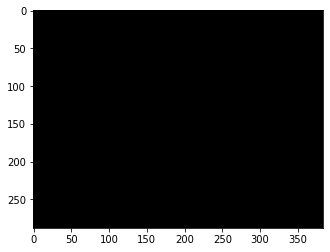

In [52]:
mask = mask[-1]

# Convert torch tensor to numpy array
mask = mask.detach().cpu().numpy()

# Convert output to a 2-d array
mask = np.squeeze(np.squeeze(mask, axis=0), axis=0)

# Convert output to binary based on threshold
mask[mask > -2.5] = 255
mask[mask <= -2.5] = 0

# Resize the ouptut image to input image size
mask = cv2.resize(mask, (im_width, im_height))

# Plot the generated mask
plt.imshow(mask, cmap="gray")

## Read and plot the ground truth mask

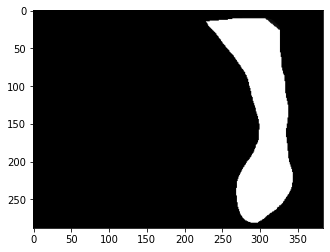

In [44]:
actual_mask = "input/PNG/Ground Truth/115.png"
am = plt.imread(actual_mask)
plt.imshow(am, cmap="gray")